<a href="https://colab.research.google.com/github/yue-zhongqi/cartpole_colab/blob/main/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q-Learning Agent for CartPole Environment

### 24/25 S2, Assignment 1

Completed By:
- Yeo Ke Jun (U2322646E), Individual Contribution

<div style="background-color: lightblue; color: white; padding: 10px; text-align: left; border-radius: 5px;">
    
</div>

## Project Overview

This notebook implements a **Q-Learning** and **Policy Gradient agent** to solve the CartPole balancing problem from OpenAI Gym/Gymnasium. The CartPole problem is a classic reinforcement learning task where a pole is attached to a cart moving along a frictionless track. The goal is to prevent the pole from falling over by applying forces to move the cart left or right. 

Both agents are model-free reinforcement learning agents, in which the agent learns directly from experience or trial-and-error and uses the feedback to update their internal policies or value functions.

### Project Structure

The project consists of the following components:

1. **Environment Setup**: Setting up the CartPole environment using either `gym` or `gymnasium`
2. **Q-Learning Implementation (1st RL agent)**: A tabular Q-Learning agent with state discretization
3. **Policy Gradient Implementation (2nd RL agent)**: A neural network-based Policy Gradient agent with a baseline value function.
4. **Task 1**: Training & Development of RL Agents
5. **Task 2**: Testing the trained agent's performance, running 100 episodes
6. **Task 3**: Visualizing the agent's learning progress and final performance, rendering a video of an episode
7. **Task 4**: Step-by-step instructions, explanations and comments for the project

### Files in the Project

- `q_learning_cartpole.ipynb`: This Jupyter notebook (the main file you're viewing now)
- `q_learning_cartpole_model.pkl`: A pickle file which saves our Q Learning Model
- `q_learning_cartpole_complete.pkl`: A pickle file which saves our Q Learning parameters/ hyperparameters
- `video`: File containing video renders for the cartpole, for both our Q Learning & Policy Gradient agents

Let's begin by importing the necessary dependencies and setting up our environment.

<div style="background-color: lightblue; color: white; padding: 10px; text-align: left; border-radius: 5px;">
    
</div>

## Installing dependencies:

In [1]:
!pip install gym
!pip install gym[classic_control]
!pip install pygame
!pip install moviepy
!pip install tensorflow
!pip install ffmpeg
!pip install imageio-ffmpeg

  Using cached ffmpeg-1.4.tar.gz (5.1 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [1 lines of output]
  ERROR: Can not execute `setup.py` since setuptools is not available in the build environment.
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

Encountered error while generating package metadata.

See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


## Importing dependencies

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay


## Helper function for the video

In [3]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

<div style="background-color: lightblue; color: white; padding: 10px; text-align: left; border-radius: 5px;">
    
</div>

## Loading the CartPole environment

Firstly, we start by initialising the Reinforcement Learning environment, using the OpenAI Gym library. We use the CartPole-v1 environment, which also provides us with some initial values & parameters for our Q-Learning algorithm.

In [4]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [5]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [6]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [7]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [ 0.01173995 -0.04093289  0.04734913  0.037074  ]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [8]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [ 0.01092129 -0.23670073  0.0480906   0.34431207]
Reward for this step: 1.0
Is this round done? False


C:\Users\kejun\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [9]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 10.0


<div style="background-color: lightblue; color: white; padding: 10px; text-align: left; border-radius: 5px;">
    
</div>

## Q-Learning Theory

Q-Learning is a model-free reinforcement learning algorithm that learns a policy to maximize the expected cumulative reward. It uses a Q-table (or Q-function) to represent the expected utility of taking a given action in a given state.

### The Q-Learning Algorithm

1. **Initialize** the Q-table with zeros or small random values
2. **For each episode**:
   - Reset the environment to get an initial state
   - **For each step in the episode**:
     - Choose an action using an exploration-exploitation strategy (e.g., epsilon-greedy)
     - Take the action, observe the reward and next state
     - Update the Q-value using the Q-learning update rule
     - Move to the next state
     - If the episode is done, break the loop

### The Q-Learning Update Rule

The Q-learning update rule is:

$$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha [r_t + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)]$$

Where:
- $Q(s_t, a_t)$ is the current Q-value for state $s_t$ and action $a_t$
- $\alpha$ is the learning rate (how quickly we update our Q-values)
- $r_t$ is the reward received after taking action $a_t$ in state $s_t$
- $\gamma$ is the discount factor (how much we value future rewards)
- $\max_a Q(s_{t+1}, a)$ is the maximum Q-value for the next state $s_{t+1}$

### State Discretization

The CartPole problem has a continuous state space, but Q-learning traditionally works with discrete states. To handle this, we'll discretize the continuous state space into buckets. The state in CartPole consists of:

1. Cart Position: -4.8 to 4.8
2. Cart Velocity: -∞ to ∞ (we'll use reasonable bounds)
3. Pole Angle: -0.418 to 0.418 radians
4. Pole Angular Velocity: -∞ to ∞ (we'll use reasonable bounds)

By discretizing each dimension into buckets, we create a finite state space that our Q-learning algorithm can handle.

<div style="background-color: lightblue; color: white; padding: 10px; text-align: left; border-radius: 5px;">
    
</div>

## Task 1: Developing & Training the Q-Learning Agent

### Implementing the Q-Learning Agent

We'll now implement our Q-Learning agent for the CartPole environment. The key components are:

#### 1. State Discretization
Converting continuous state values to discrete buckets to create a manageable state space for our Q-table.
Problem: The cart-pole environment has **continuous values** (e.g. angle = 0.7, velocity = 1.2 m/s). Q-Learning works best with discrete states. Hence, we split continuous values into bins/ slots.

#### 2. Q-table Initialization
Creating a table to store state-action values, initialized with optimistic values to encourage exploration.

#### 3. Action Selection Policy
Using an epsilon-greedy policy to balance exploration (trying new actions) and exploitation (using known good actions).

#### 4. Q-value Update Rule
Implementing the Q-learning update rule to learn from experience.

#### 5. Training Process
Run it for many episodes, where in each episode, environment is reset, and rewards are stored to track progress.

<div style="background-color: lightblue; color: white; padding: 10px; text-align: left; border-radius: 5px;">
    
</div>

### Initialising parameters, discretization of states

In [10]:
env = gym.make("CartPole-v1")

# initialise values
env = gym.make("CartPole-v1")

alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor (slightly reduced from 1.0)
epsilon = 0.1  # Initial exploration rate
min_epsilon = 0.01  # Minimum exploration rate
epsilon_decay = 0.9995  # Epsilon decay rate

# State discretization bins
numberOfBinsPosition = 20
numberOfBinsVelocity = 20
numberOfBinsAngle = 40
numberOfBinsAngleVelocity = 40
numberOfBins = [numberOfBinsPosition, numberOfBinsVelocity, numberOfBinsAngle, numberOfBinsAngleVelocity]
actionNumber = env.action_space.n

# Initialize Q-matrix
Qmatrix = np.random.uniform(low=0, high=1, size=(numberOfBins[0], numberOfBins[1], numberOfBins[2], numberOfBins[3], actionNumber))

# Set environment bounds
upperBounds = env.observation_space.high
lowerBounds = env.observation_space.low
cartVelocityMin = -3
cartVelocityMax = 3
poleAngleVelocityMin = -10
poleAngleVelocityMax = 10
upperBounds[1] = cartVelocityMax
upperBounds[3] = poleAngleVelocityMax
lowerBounds[1] = cartVelocityMin
lowerBounds[3] = poleAngleVelocityMin

## State Discretization Function for Q-Learning

The `returnIndexState` function is a crucial component of our Q-learning implementation for the CartPole environment. This function transforms the continuous state space of the CartPole problem into a discrete representation that can be used as indices for our Q-matrix.

### Function Process:

1. **State Variable Extraction**: 
   - Extracts the four continuous state variables from the input array:
     - `position`: The cart's horizontal position
     - `velocity`: The cart's velocity
     - `angle`: The pole's angle relative to vertical
     - `angularVelocity`: The pole's angular velocity

2. **Discretization Bins Creation**: 
   - Creates evenly spaced bins for each state variable using `np.linspace`
   - Each dimension's range (from lower to upper bounds) is divided into the specified number of bins

3. **State Discretization**: 
   - Uses `np.digitize` to determine which bin each continuous state value belongs to
   - This effectively converts continuous values to discrete indices

4. **Index Adjustment**: 
   - Subtracts 1 from the digitized values to convert from 1-based indexing (returned by `np.digitize`) to 0-based indexing
   - Uses `np.maximum` to ensure no negative indices are produced

5. **Return Value**: 
   - Returns a tuple of four integers representing the discretized state
   - This tuple serves as an index into our Q-matrix

This discretization approach allows our agent to generalize across similar states and makes the learning problem tractable by reducing the infinite continuous state space to a finite discrete representation.


In [11]:
def returnIndexState(state):

    # extracting values from the state array into their rightful variables
    position = state[0]
    velocity = state[1]
    angle = state[2]
    angularVelocity = state[3]

    # creates the bins for each of the states using np.linspace function
    cartPositionBin = np.linspace(lowerBounds[0], upperBounds[0],numberOfBins[0])
    cartVelocityBin = np.linspace(lowerBounds[1], upperBounds[1],numberOfBins[1])
    poleAngleBin = np.linspace(lowerBounds[2], upperBounds[2],numberOfBins[2])
    poleAngleVelocityBin = np.linspace(lowerBounds[3], upperBounds[3],numberOfBins[3])

    # returns the index of the closest bin to the state, -1 to adjust the indices returned by np.digitize to start from zero instead of one
    indexPosition=np.maximum(np.digitize(position, cartPositionBin)-1,0)
    indexVelocity=np.maximum(np.digitize(velocity, cartVelocityBin)-1,0)
    indexAngle=np.maximum(np.digitize(angle, poleAngleBin)-1,0)
    indexAngularVelocity=np.maximum(np.digitize(angularVelocity, poleAngleVelocityBin)-1,0)

    return tuple([indexPosition, indexVelocity, indexAngle, indexAngularVelocity])

## Action Selection Strategy for Q-Learning Agent

The `selectAction` function implements an epsilon-greedy action selection strategy for our Q-learning agent in the CartPole environment. This function balances exploration and exploitation to optimize the agent's learning process.

### Function Process:

1. **Initial Exploration Phase**:
   - For the first 500 episodes during training (`index < 500 and isTraining`), the agent selects completely random actions
   - This ensures thorough exploration of the state space early in training

2. **Epsilon Decay Mechanism**:
   - After 5000 episodes (`index > 5000 and isTraining`), the exploration rate (epsilon) gradually decreases
   - Epsilon is reduced by multiplying it by a decay factor (`epsilon_decay`)
   - A minimum epsilon value (`min_epsilon`) prevents exploration from dropping too low

3. **Epsilon-Greedy Decision**:
   - With probability epsilon, the agent selects a random action (exploration)
   - With probability (1-epsilon), the agent selects the action with the highest Q-value (exploitation)

4. **Greedy Action Selection**:
   - When exploiting, the agent first converts the continuous state to a discretized index using `returnIndexState`
   - It then identifies the action(s) with the maximum Q-value for that state
   - If multiple actions have the same maximum Q-value, one is randomly chosen

This approach allows the agent to initially explore the environment broadly, then gradually shift toward exploiting its learned knowledge, while always maintaining some level of exploration to discover potentially better strategies.


In [12]:
def selectAction(state, index, isTraining):
    global epsilon
    
    # For the first 500 episodes, use more exploration
    if index < 500 and isTraining:
        return np.random.choice(actionNumber)
    
    # Decay epsilon after episode 5000 instead of 7000
    if index > 5000 and isTraining:
        epsilon = max(min_epsilon, epsilon * epsilon_decay)
    
    # Epsilon-greedy action selection
    if np.random.random() < epsilon:
        return np.random.choice(actionNumber)
    else:
        state_index = returnIndexState(state)
        return np.random.choice(np.where(Qmatrix[state_index] == np.max(Qmatrix[state_index]))[0])

## Training the RL agent

In [13]:
def simulateEpisodes(numberEpisodes, isTraining):
    # List to store the sum of rewards for every 1000 episodes
    sumRewardsPer1000Episodes = []
    totalReward = 0  # Accumulate rewards over 1000 episodes

    for indexEpisode in range(numberEpisodes):
        # List that stores rewards per episode
        rewardsEpisode = []

        # Reset the environment at the beginning of every episode
        stateS = env.reset()
        stateS = list(stateS)

        # Stepping from one state to another
        # Loop until a terminal state is reached
        terminalState = False
        while not terminalState:
            # Return a discretized index of the state
            stateSIndex = returnIndexState(stateS)

            # Select an action on the basis of the current state, denoted by stateS
            actionA = selectAction(stateS, indexEpisode, isTraining)

            # Step and return the state, reward, and boolean denoting if the state is a terminal state
            stateSprime, reward, terminalState, _ = env.step(actionA)

            rewardsEpisode.append(reward)
            stateSprime = list(stateSprime)
            stateSprimeIndex = returnIndexState(stateSprime)

            # Return the max value, we do not need actionAprime
            QmaxPrime = np.max(Qmatrix[stateSprimeIndex])

            if not terminalState:
                # Update Q-value using the Bellman equation
                error = reward + gamma * QmaxPrime - Qmatrix[stateSIndex + (actionA,)]
                Qmatrix[stateSIndex + (actionA,)] += alpha * error
            else:
                # In the terminal state, Qmatrix[stateSprime, actionAprime] = 0
                error = reward - Qmatrix[stateSIndex + (actionA,)]
                Qmatrix[stateSIndex + (actionA,)] += alpha * error

            stateS = stateSprime

        # Accumulate the total reward for the episode
        totalReward += np.sum(rewardsEpisode)

        # Print average reward every 1000 episodes
        if (indexEpisode + 1) % 1000 == 0:
            averageReward = totalReward / 1000
            sumRewardsPer1000Episodes.append(averageReward)
            print(f"Episode {indexEpisode + 1}: Average reward over last 1000 episodes = {averageReward:.2f}")
            totalReward = 0  # Reset for the next 1000 episodes

    return sumRewardsPer1000Episodes

In [14]:
Qmatrix=np.random.uniform(low=0, high=1, size=(numberOfBins[0],numberOfBins[1],numberOfBins[2],numberOfBins[3],actionNumber))

# run 15000 episodes for training, prioritise initial exploration
simulateEpisodes(15000, True)

Episode 1000: Average reward over last 1000 episodes = 72.33
Episode 2000: Average reward over last 1000 episodes = 158.13
Episode 3000: Average reward over last 1000 episodes = 171.53
Episode 4000: Average reward over last 1000 episodes = 173.62
Episode 5000: Average reward over last 1000 episodes = 181.24
Episode 6000: Average reward over last 1000 episodes = 183.72
Episode 7000: Average reward over last 1000 episodes = 202.15
Episode 8000: Average reward over last 1000 episodes = 189.42
Episode 9000: Average reward over last 1000 episodes = 184.05
Episode 10000: Average reward over last 1000 episodes = 195.21
Episode 11000: Average reward over last 1000 episodes = 196.69
Episode 12000: Average reward over last 1000 episodes = 217.26
Episode 13000: Average reward over last 1000 episodes = 197.04
Episode 14000: Average reward over last 1000 episodes = 190.44
Episode 15000: Average reward over last 1000 episodes = 207.36


[72.334,
 158.127,
 171.53,
 173.625,
 181.244,
 183.715,
 202.146,
 189.416,
 184.046,
 195.209,
 196.694,
 217.258,
 197.037,
 190.436,
 207.359]

### Saving the trained Q-Learning Agent into a pickle file

In [15]:
import pickle

# After training your Q-learning agent
# Save the Q-matrix to a pickle file
with open('q_learning_cartpole_model.pkl', 'wb') as f:
    pickle.dump(Qmatrix, f)

# To load the model later
with open('q_learning_cartpole_model.pkl', 'rb') as f:
    loaded_Qmatrix = pickle.load(f)


In [16]:
# Save multiple components
model_data = {
    'Qmatrix': Qmatrix,
    'alpha': alpha,
    'gamma': gamma,
    'epsilon': epsilon,
    'numberOfBins': numberOfBins,
    'upperBounds': upperBounds,
    'lowerBounds': lowerBounds
}

with open('q_learning_cartpole_parameters.pkl', 'wb') as f:
    pickle.dump(model_data, f)

# Load the complete model
with open('q_learning_cartpole_parameters.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
    loaded_Qmatrix = loaded_model['Qmatrix']

<div style="background-color: lightblue; color: white; padding: 10px; text-align: left; border-radius: 5px;">
    
</div>

## Task 2: Demonstrate the effectiveness of the Q-Learning RL agent

Now we'll evaluate our Q-Learning agent by running it for 100 episodes and recording the cumulative reward for each episode. This evaluation will:

1. **Test the agent's policy**: We'll use the learned Q-values to select actions
2. **Measure performance**: Calculate the average reward over 100 episodes
3. **Verify solution**: Check if the average reward exceeds 195, which is the threshold for considering the CartPole problem solved

The CartPole environment is considered solved when the agent achieves an average reward of 195 or more over 100 consecutive episodes.

Episodes 1-10: Average reward = 237.50
Episodes 11-20: Average reward = 230.90
Episodes 21-30: Average reward = 239.10
Episodes 31-40: Average reward = 224.70
Episodes 41-50: Average reward = 230.10
Episodes 51-60: Average reward = 221.20
Episodes 61-70: Average reward = 250.60
Episodes 71-80: Average reward = 226.10
Episodes 81-90: Average reward = 220.50
Episodes 91-100: Average reward = 216.90


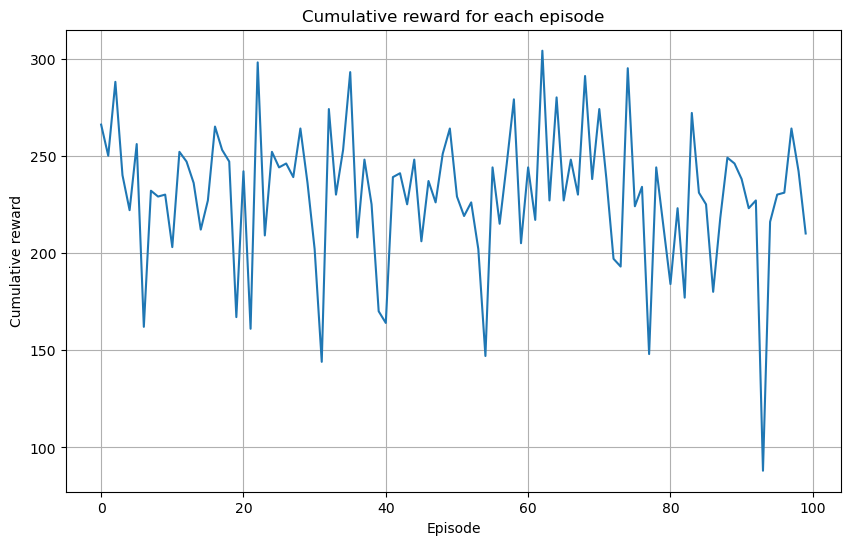

Overall average cumulative reward: 229.76
Is my agent good enough? True


In [17]:
# Task 2: Demonstrate the effectiveness of the RL agent (printing average every 10 episodes)

# Play the game for 100 episodes using your Q-learning agent
episode_results = []
env = gym.make("CartPole-v1")

for episode_batch in range(10):  # 10 batches of 10 episodes each
    batch_rewards = []
    
    # Run 10 episodes per batch
    for episode in range(10):
        observation = env.reset()
        observation = list(observation)  # Convert to list as your agent expects
        cumulative_reward = 0
        done = False
        
        while not done:
            # Get the action from your Q-learning agent
            action = selectAction(observation, 8000, False)  # Using low epsilon for exploitation
            
            # Take the action and observe the result
            observation, reward, done, info = env.step(action)
            observation = list(observation)  # Convert to list as your agent expects
            
            # Accumulate reward
            cumulative_reward += reward
        
        # Record the cumulative reward for this episode
        batch_rewards.append(cumulative_reward)
        episode_results.append(cumulative_reward)
    
    # Print average reward for this batch of 10 episodes
    batch_average = np.mean(batch_rewards)
    print(f"Episodes {episode_batch*10+1}-{(episode_batch+1)*10}: Average reward = {batch_average:.2f}")

# Convert to numpy array for easier analysis
episode_results = np.array(episode_results)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('Episode')
plt.grid(True)
plt.show()

# Print overall average reward
print("Overall average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)


#### Our Q-Learning agent passes the test!

<div style="background-color: lightblue; color: white; padding: 10px; text-align: left; border-radius: 5px;">
    
</div>

## Task 3: Render one episode played by the Q-Learning Agent

Plug your agent to the code below to obtain rendered result.

In [29]:
# Task 3: Render one episode played by the agent
from gym.wrappers import RecordVideo

# Create a wrapped environment for video recording
env = RecordVideo(gym.make("CartPole-v1"), "./video", name_prefix="qlearning")

# Reset the environment
observation = env.reset()
observation = list(observation)  # Convert to list as your agent expects
done = False

# Run one episode with your trained agent
while not done:
    env.render()
    
    # Get action from your Q-learning agent
    action = selectAction(observation, 8000, False)  # Using low epsilon for exploitation
    
    # Take the action and observe the result
    observation, reward, done, info = env.step(action)
    observation = list(observation)  # Convert to list as your agent expects

env.close()

# Use your existing show_video function
show_video()


<div style="background-color: lightblue; color: white; padding: 10px; text-align: left; border-radius: 5px;">
    
</div>

# Policy Gradient Agent for CartPole Problem

## Policy Gradient Implementation for CartPole

This implementation uses a Policy Gradient approach with a baseline value function to solve the CartPole environment. Unlike the Q-learning approach that discretizes the state space, Policy Gradient directly learns a policy function that maps states to action probabilities.

### Key Components

1. **Neural Network Architecture**
   - A small policy network with a single hidden layer of 16 neurons
   - ReLU activation for the hidden layer and softmax for the output layer
   - Dropout regularization (5%) to prevent overfitting
   - A separate value network to estimate state values and reduce variance

2. **Hyperparameters**
   - Discount factor (gamma): 0.999
   - Learning rate: 0.001
   - Entropy coefficient: 0.01
   - Gradient clipping threshold: 0.5

3. **Training Process**
   - For each episode:
     - Collect trajectory data (states, actions, rewards)
     - Calculate discounted returns
     - Normalize rewards for training stability
     - Update policy network using policy gradients
     - Update value network to better estimate state values

4. **Advantage Calculation**
   - Uses the value network as a baseline to reduce variance
   - Advantage = Discounted return - Value estimate
   - This helps distinguish good actions from lucky ones

5. **Exploration Strategy**
   - Uses entropy regularization to encourage exploration
   - Samples actions from the policy's probability distribution during training
   - Takes the most probable action during evaluation

### Mathematical Function

The policy gradient method implemented in our solution uses the following core mathematical function:

$$\nabla_\theta J(\theta) = \mathbb{E}_{\pi_\theta} [\nabla_\theta \log \pi_\theta(s, a) \cdot A(s, a)]$$

Where:
- $\nabla_\theta J(\theta)$ is the gradient of the expected return with respect to policy parameters $\theta$
- $\pi_\theta$ is our policy network parameterized by $\theta$
- $\nabla_\theta \log \pi_\theta(s, a)$ is the score function (gradient of log probability of taking action $a$ in state $s$)
- $A(s, a)$ is the advantage function, which we estimate as $R - V(s)$

In our implementation, we use a baseline value function to reduce variance, resulting in the following update rule:

$$\theta \leftarrow \theta + \alpha \cdot \nabla_\theta \log \pi_\theta(s, a) \cdot (R - V(s))$$

Where:
- $\alpha$ is the learning rate (0.001 in our implementation)
- $R$ is the discounted return calculated as $\sum_{t=0}^{T} \gamma^t r_t$ with $\gamma = 0.999$
- $V(s)$ is the baseline value function estimate

We also incorporate entropy regularization to encourage exploration:

$$L(\theta) = -\mathbb{E}_{\pi_\theta} [\log \pi_\theta(s, a) \cdot A(s, a)] - \beta \cdot H(\pi_\theta)$$

Where:
- $L(\theta)$ is the loss function to minimize
- $H(\pi_\theta)$ is the entropy of the policy
- $\beta$ is the entropy coefficient (0.01 in our implementation)

This approach allows us to directly optimize the policy without discretizing the state space, which is more suitable for the continuous state space of the CartPole environment.

### Advantages Over Q-Learning

1. **No Discretization**: Works directly with continuous state spaces
2. **Stochastic Policy**: Naturally handles exploration through probability distributions
3. **Policy Optimization**: Directly optimizes the policy rather than deriving it from value functions
4. **Simpler Architecture**: Effective with smaller networks (16 neurons vs. 30×30×30×30 state-action table)

This implementation combines policy gradients with a value baseline (actor-critic style) to achieve stable and efficient learning in the CartPole environment.


<div style="background-color: lightblue; color: white; padding: 10px; text-align: left; border-radius: 5px;">
    
</div>

### Loading the CartPole Environment

In [19]:
env = gym.make('CartPole-v1')

### Initialising Parameters

In [20]:
# hyperparameter initialisation

gamma_PG = 0.999 # discount factor
learning_rate_PG = 0.001
input_dim_PG = 4 # cartpole state space dimension
output_dim_PG = 2 # cartpole action space (either left or right)
hidden_size_PG = 16
entropy_beta = 0.01
dropout_rate = 0.05
#max_steps_PG = 
#update_frequency_PG = 

### Defining the Policy Network

In [21]:
# Define the policy network
class PolicyNetwork(tf.keras.Model):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.dense1 = tf.keras.layers.Dense(hidden_size_PG, activation='relu', 
                                           kernel_initializer=tf.keras.initializers.he_normal())
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense2 = tf.keras.layers.Dense(output_dim_PG, activation=None)
        
    def call(self, x, training=False):
        x = self.dense1(x)
        if training:
            x = self.dropout(x)
        x = self.dense2(x)
        return x
    
    def action_probs(self, x, training=False):
        logits = self.call(x, training)
        return tf.nn.softmax(logits)

# Create policy network and optimizer with learning rate schedule
policy_network = PolicyNetwork()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate_PG,
    decay_steps=1000,
    decay_rate=0.95)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Create a baseline value network to reduce variance
class ValueNetwork(tf.keras.Model):
    def __init__(self):
        super(ValueNetwork, self).__init__()
        self.dense1 = tf.keras.layers.Dense(hidden_size_PG, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1)
        
    def call(self, x):
        x = self.dense1(x)
        return self.dense2(x)

# Create value network and optimizer
value_network = ValueNetwork()
value_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_PG)


### Defining utility functions for Rewards

In [22]:
# Define utility functions for rewards
# Function to calculate discounted rewards
def discount_rewards(rewards):
    discounted_rewards = np.zeros_like(rewards, dtype=np.float32)
    running_add = 0
    for t in reversed(range(len(rewards))):
        running_add = running_add * gamma_PG + rewards[t]
        discounted_rewards[t] = running_add
    return discounted_rewards

# Improved reward normalization
def normalize_rewards(rewards):
    rewards = np.array(rewards)
    if len(rewards) > 1:
        return (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-8)
    return rewards


### Defining the Training Step Function

In [23]:
# Define training step function with baseline and entropy regularization
@tf.function
def train_step(states, actions, rewards):
    with tf.GradientTape() as policy_tape, tf.GradientTape() as value_tape:
        # Forward pass through policy network
        logits = policy_network(states, training=True)
        action_probs = tf.nn.softmax(logits)
        
        # Forward pass through value network
        values = value_network(states)
        
        # Create a mask for the taken actions
        action_masks = tf.one_hot(actions, output_dim_PG)
        
        # Calculate advantage (rewards - baseline)
        advantages = rewards - tf.squeeze(values)
        
        # Calculate policy loss (negative log probability weighted by advantages)
        selected_action_probs = tf.reduce_sum(action_probs * action_masks, axis=1)
        log_probs = tf.math.log(selected_action_probs + 1e-10)
        policy_loss = -tf.reduce_mean(log_probs * advantages)
        
        # Add entropy regularization to encourage exploration
        entropy = -tf.reduce_mean(tf.reduce_sum(action_probs * tf.math.log(action_probs + 1e-10), axis=1))
        policy_loss -= entropy_beta * entropy
        
        # Calculate value loss (MSE between predicted values and discounted rewards)
        value_loss = tf.reduce_mean(tf.square(rewards - tf.squeeze(values)))
    
    # Calculate gradients and apply clipping
    policy_gradients = policy_tape.gradient(policy_loss, policy_network.trainable_variables)
    value_gradients = value_tape.gradient(value_loss, value_network.trainable_variables)
    
    # Clip gradients to prevent large updates
    policy_gradients, _ = tf.clip_by_global_norm(policy_gradients, 0.5)
    value_gradients, _ = tf.clip_by_global_norm(value_gradients, 0.5)
    
    # Apply gradients
    optimizer.apply_gradients(zip(policy_gradients, policy_network.trainable_variables))
    value_optimizer.apply_gradients(zip(value_gradients, value_network.trainable_variables))
    
    return policy_loss, value_loss, entropy


### Defining the Training Loop Function

In [24]:
# Define training loop function
def train_policy_gradient(num_episodes=2000, render_frequency=None):
    episode_rewards = []
    avg_rewards_list = []
    
    for episode in range(num_episodes):
        # Reset environment
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]  # Handle newer gym versions
        
        # Initialize episode data
        states = []
        actions = []
        rewards = []
        episode_reward = 0
        done = False
        
        # Run one episode
        while not done:
            # Render environment occasionally if specified
            if render_frequency and episode % render_frequency == 0:
                env.render()
            
            # Get action probabilities from policy network
            state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)
            action_probs = tf.nn.softmax(policy_network(state_tensor))[0].numpy()
            
            # Sample action from probability distribution
            action = np.random.choice(output_dim_PG, p=action_probs)
            
            # Take action in environment
            next_state, reward, done, *_ = env.step(action)
            
            # Store step data
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            episode_reward += reward
            
            # Update state
            state = next_state
        
        # Process episode data
        episode_rewards.append(episode_reward)
        
        # Calculate discounted and normalized rewards
        discounted_rewards = discount_rewards(rewards)
        normalized_rewards = normalize_rewards(discounted_rewards)
        
        # Convert to tensors
        states_tensor = tf.convert_to_tensor(states, dtype=tf.float32)
        actions_tensor = tf.convert_to_tensor(actions, dtype=tf.int32)
        rewards_tensor = tf.convert_to_tensor(normalized_rewards, dtype=tf.float32)
        
        # Update policy network
        policy_loss, value_loss, entropy = train_step(states_tensor, actions_tensor, rewards_tensor)
        
        # Track progress
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_rewards_list.append(avg_reward)
            print(f"Episode {episode + 1}: Average reward over last 100 episodes = {avg_reward:.2f}")
            
            # Check if environment is solved, give buffer
            if avg_reward >= 300.0 and episode >= 100:
                print(f"Environment solved in {episode + 1} episodes!")
                break
    
    return episode_rewards, avg_rewards_list


### Training the Policy Gradient Agent

C:\Users\kejun\anaconda3\Lib\site-packages\keras\src\layers\layer.py:361: UserWarning: `build()` was called on layer 'policy_network', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Episode 100: Average reward over last 100 episodes = 49.49
Episode 200: Average reward over last 100 episodes = 55.74
Episode 300: Average reward over last 100 episodes = 65.84
Episode 400: Average reward over last 100 episodes = 74.88
Episode 500: Average reward over last 100 episodes = 92.45
Episode 600: Average reward over last 100 episodes = 96.93
Episode 700: Average reward over last 100 episodes = 112.32
Episode 800: Average reward over last 100 episodes = 148.56
Episode 900: Average reward over last 100 episodes = 167.34
Episode 1000: Average reward over last 100 episodes = 171.06
Episode 1100: Average reward over last 100 episodes = 187.43
Episode 1200: Average reward over last 100 episodes = 223.41
Episode 1300: Average reward over last 100 episodes = 214.44
Episode 1400: Average reward over last 100 episodes = 252.00
Episode 1500: Average reward over last 100 episodes = 268.50
Episode 1600: Average reward over last 100 episodes = 317.08
Environment solved in 1600 episodes!


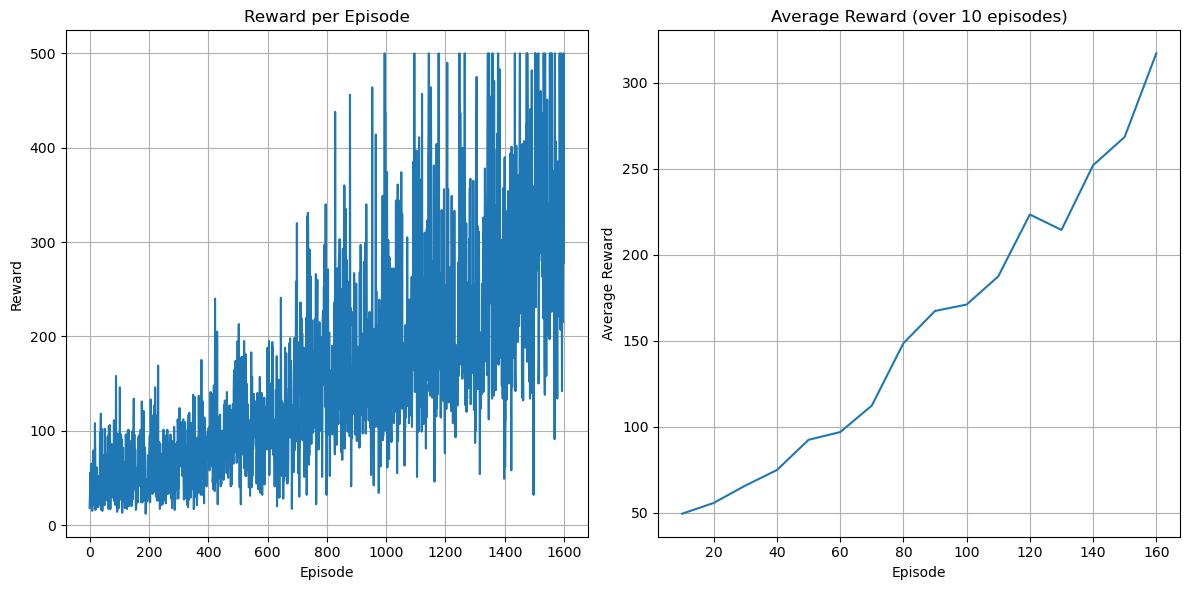

In [25]:
# Train the agent
episode_rewards, avg_rewards = train_policy_gradient(num_episodes=2000)

# Plot training results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.title('Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(10, len(avg_rewards)*10 + 1, 10), avg_rewards)
plt.title('Average Reward (over 100 episodes)')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.grid(True)
plt.tight_layout()
plt.show()


<div style="background-color: lightblue; color: white; padding: 10px; text-align: left; border-radius: 5px;">
    
</div>

## Task 2: Testing the Effectiveness of Policy Gradient Agent

In [26]:
def test_policy_gradient(num_episodes=100):
    test_rewards = []
    
    for episode in range(num_episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
            
        episode_reward = 0
        done = False
        
        while not done:
            # Get action probabilities
            state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)
            action_probs = policy_network(state_tensor)[0].numpy()
            
            # Take most probable action (no exploration during testing)
            action = np.argmax(action_probs)
            
            # Take action in environment
            state, reward, done, *_ = env.step(action)
            episode_reward += reward
        
        test_rewards.append(episode_reward)
        
    # Calculate average reward
    avg_reward = np.mean(test_rewards)
    print(f"Average test reward over {num_episodes} episodes: {avg_reward:.2f}")
    print(f"Is agent good enough? {avg_reward > 195}")
    
    # Plot test rewards
    plt.figure(figsize=(10, 6))
    plt.plot(test_rewards)
    plt.title('Test Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True)
    plt.show()
    
    return test_rewards


Average test reward over 100 episodes: 493.67
Is agent good enough? True


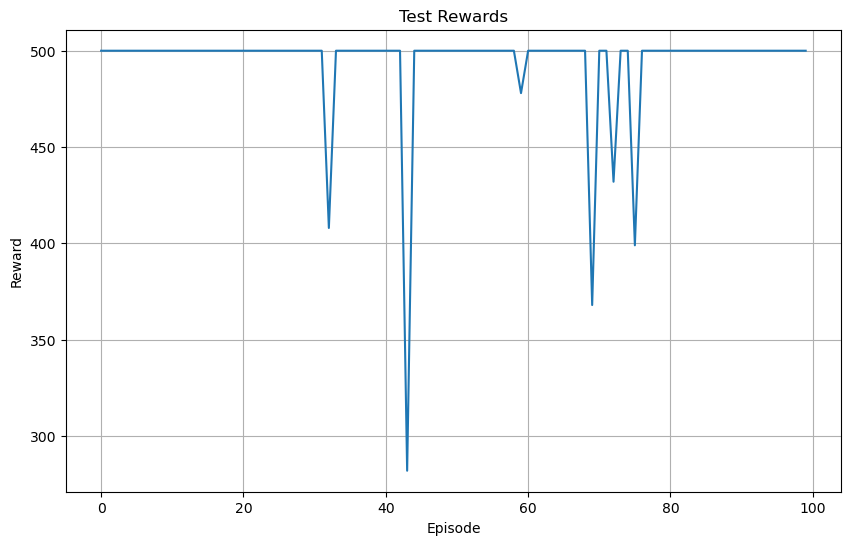

In [27]:
# testing the agent
test_rewards = test_policy_gradient(100)


#### Our Q-Learning agent passes the test!

As per the results above, we can see that our Policy Gradient agent "passes" the test in Task 2 with flying colours, clocking in an average cumulative reward of **493.67** over 100 episodes played. We can also see that our Policy Gradient agent hits the maximum cumulative reward ceiling of 500 multiple times, which proves that it is a superb reinforcement learning agent.

<div style="background-color: lightblue; color: white; padding: 10px; text-align: left; border-radius: 5px;">
    
</div>

## Task 3: Render one episode played by the Policy Gradient Agent

In [30]:
#Render one episode played by the agent
from gym.wrappers import RecordVideo

# Create a wrapped environment for video recording
env = RecordVideo(gym.make("CartPole-v1"), "./video", name_prefix="policy_gradient")

# Reset the environment
observation = env.reset()
if isinstance(observation, tuple):
    observation = observation[0]  # Handle newer gym versions
done = False

# Run one episode with your trained agent
while not done:
    env.render()
    
    # Get action from your Policy Gradient agent
    state_tensor = tf.convert_to_tensor([observation], dtype=tf.float32)
    action_probs = policy_network(state_tensor)[0].numpy()
    action = np.argmax(action_probs)  # Take most probable action during testing
    
    # Take the action and observe the result
    observation, reward, done, info = env.step(action)
    if isinstance(observation, tuple):
        observation = observation[0]

env.close()

# Use your existing show_video function
show_video()


<div style="background-color: lightblue; color: white; padding: 10px; text-align: left; border-radius: 5px;">
    
</div>

*Note: Typo(s)*
- For Cell 25, plot title "Average Reward (over 10 episodes)" should be Average Reward (over 100 episodes) instead.
- For Cell 25, x-axis for the same plot, episode results are from episode 0 to 1600, not 0 to 160.

## Thank You for Reading!

Do feel free to contact me @ YE0003UN@e.ntu.edu.sg if the code is unable to run on your local machine, or if you have any queries. Thank You!
